<a href="https://colab.research.google.com/github/vysf/seismologi-terapan/blob/master/Instrument_Adjustment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tujuan


1.   Implementasi Baseline Correction, Time Shifting, Frequency Filtering, Fourier Transform.
2.   Mendapatkan Instrument Adjustment Factor.



## Download modul obspy

hint: `!pip install nama_modul`

In [ ]:
# !pip install obspy

## Upload File Instrument

Import modul yang diperlukan


1.   `obspy`: seismic processing tool. [doc](https://docs.obspy.org/index.html)
2.   `numpy`: fundamental package for scientific computing in Python. [doc](https://numpy.org/doc/stable/index.html)
3.   `pandas`: data structures and data analysis tools. [doc](https://pandas.pydata.org/docs/index.html)
4.   `Matplotlib`: data visualization tool. [doc](https://matplotlib.org/)




In [ ]:
import obspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

buat fungsi helper

In [ ]:
def read_data(files: list[str], verbose=False) -> list:
  """
  Membaca multi file seismik

  Parameter
  ---------
  files : list[str]
      Daftar nama file.

  verbose : bool
      Menampilkan file yang dibaca, default adalah False.\n
      Jika True maka akan menampilkan file-file yang dibaca.

  Returns
  -------
  streams : list[obspy.core.stream.Stream]
      Daftar object `obspy.core.stream.Stream`.
  """
  streams = []
  for idx, ifile in enumerate(files):
    streams.append(obspy.read(ifile))
    if verbose: print(f"Read file: {ifile}")
  return streams

Baca file instrumen yang akan diolah

In [ ]:
adjustment_files = ["KAL_4.mseed", "KAL_5.mseed", "KAL_6.mseed"]
streams = read_data(adjustment_files, verbose=True)

Read file: KAL_4.mseed
Read file: KAL_5.mseed
Read file: KAL_6.mseed


Cek kelengkapan trace

In [ ]:
streams

[3 Trace(s) in Stream:
.KAL_4..BHE | 2022-07-05T12:00:00.230000Z - 2022-07-05T13:00:00.990000Z | 100.0 Hz, 360077 samples
.KAL_4..BHN | 2022-07-05T12:00:00.230000Z - 2022-07-05T13:00:00.990000Z | 100.0 Hz, 360077 samples
.KAL_4..BHZ | 2022-07-05T12:00:00.230000Z - 2022-07-05T13:00:00.990000Z | 100.0 Hz, 360077 samples,
 3 Trace(s) in Stream:
.KAL_5..BHE | 2022-07-05T12:00:00.090000Z - 2022-07-05T13:00:00.610000Z | 100.0 Hz, 360053 samples
.KAL_5..BHN | 2022-07-05T12:00:00.090000Z - 2022-07-05T13:00:00.610000Z | 100.0 Hz, 360053 samples
.KAL_5..BHZ | 2022-07-05T12:00:00.090000Z - 2022-07-05T13:00:00.610000Z | 100.0 Hz, 360053 samples,
 3 Trace(s) in Stream:
.KAL_6..BHE | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHN | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHZ | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples]

Hapus trace yang tidak digunakan

In [ ]:
# streams[0].pop(1)
# streams[0].pop(1)

Cek kembali trace yang siap digunakan

In [ ]:
# for stream in streams:
#   print(stream)

Mari cek informasi header tiap trace pada stream

In [ ]:
for idx, stream in enumerate(streams):
  print(f"Data ke - {idx+1}")
  print(stream[2].stats)
  print("\n")

Data ke - 1
         network: 
         station: KAL_4
        location: 
         channel: BHZ
       starttime: 2022-07-05T12:00:00.230000Z
         endtime: 2022-07-05T13:00:00.990000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 360077
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 3159, 'encoding': 'FLOAT32', 'byteorder': '>', 'record_length': 512, 'filesize': 4852224})


Data ke - 2
         network: 
         station: KAL_5
        location: 
         channel: BHZ
       starttime: 2022-07-05T12:00:00.090000Z
         endtime: 2022-07-05T13:00:00.610000Z
   sampling_rate: 100.0
           delta: 0.01
            npts: 360053
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 3159, 'encoding': 'FLOAT32', 'byteorder': '>', 'record_length': 512, 'filesize': 4852224})


Data ke - 3
         network: 
         station: KAL_6
     

In [ ]:
def visualize(stream, suptitle):
  """
  Membaca multi file seismik

  Parameter
  ---------
  stream : obspy.core.stream.Stream
    object `obspy.core.stream.Stream`.

  suptitle : str
    judul plot.
  """
  colors = ["r", "g", "b"]
  fig, ax = plt.subplots(3, 1, figsize=(16, 8), dpi=75, sharex=True)

  fig.suptitle(suptitle)
  for i, (trace, color) in enumerate(zip(stream, colors)):
    time = trace.times()
    data = trace.data

    ax[i].plot(time, data, color)
    ax[i].set_title(f"{trace.stats.channel[-1]}")
    ax[i].set_ylabel("amplitude")
    ax[i].set_xlim(min(time),max(time))
    ax[i].grid('both')

    if i == len(stream)-1:
      ax[i].set_xlabel("time (second)")

Inisialisasi parameter yang akan digunakan pada pengolahan

In [ ]:
def baseline_correction(trace):
  r"""
  melakukan baseline correction.
  .. math::
    d_{b}(t) = d_r(t) - \overline{d_{r}}

  Parameters
  ---------
  trace : obspy.core.trace.Trace
    object `obspy.core.trace.Trace`.

  Returns
  ---------
  ndarray
    baseline correction calculation
  """
  return trace.data - np.mean(trace.data)

def time_shifting(trace, shift):
  """
  melakukan pergeseran waktu.

  Parameters
  ---------
  trace : obspy.core.trace.Trace
    object `obspy.core.trace.Trace`.

  shift : int
    berapa langkah pergeseran waktu, jika bernilai positif akan digeser ke kanan\n
    jika bernilai positif akan digeser ke kiri.

  Returns
  ---------
  ndarray
    pergeseran waktu
  """
  return np.roll(trace.data, shift)

def bandpass_filter(trace, freqmin, freqmax):
  """
  melakukan bandpass filter.

  Parameters
  ---------
  trace : obspy.core.trace.Trace
    object `obspy.core.trace.Trace`.

  freqmin : int or float
    frekuensi minimum.

  freqmax : int or float
    frekuensi maksimum.

  Returns
  ---------
  ndarray
    trace seismik yang telah difilter dalam domain waktu
  """
  return trace.filter("bandpass", freqmin=freqmin, freqmax=freqmax, zerophase=True)#.data[start:end]

def time_trimming(trace, start, end):
  """
  trim by data point, not by UTCDateTime

  Parameters
  ---------
  trace : obspy.core.trace.Trace
    object `obspy.core.trace.Trace`.

  start : int
    index mulai.

  end : int
    index selesai.

  Returns
  ---------
  ndarray
    trace seismik yang telah diseleksi berdasarkan rentang index
  """
  return trace.data[start:end]

In [ ]:
min_freq = 1
max_freq = 5
start_data = 1000 # n-point
data_length = 350000 # n-point
shiftdata = [0, -15, 11]

preprocessing sebelum menghasilkan instrument adjustment.
Tahapan yang dilakukan:


1.   Baseline Correction
2.   Time Shifting
3.   Frequency Filtering
4.   Fourier Transform



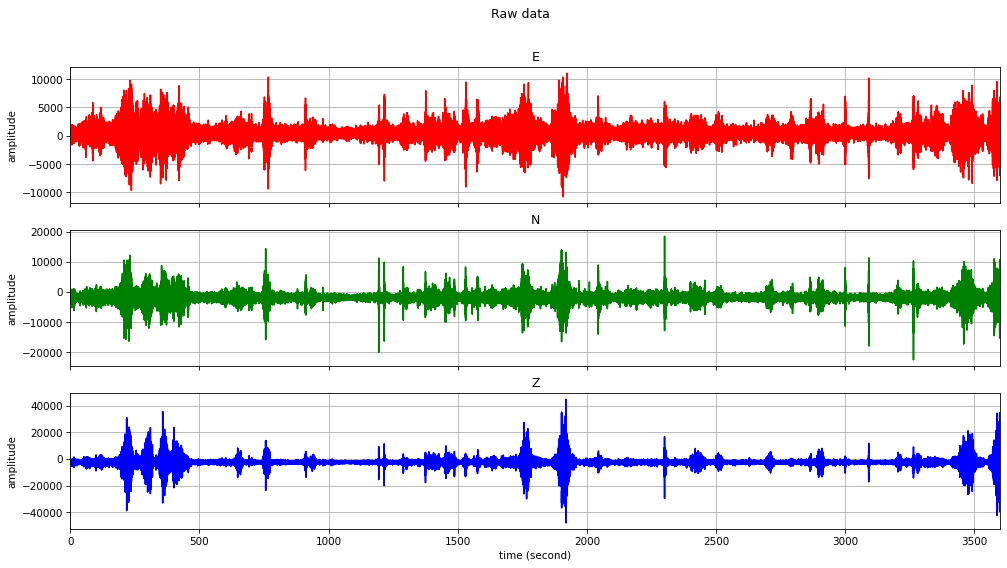

In [ ]:
visualize(streams[0], "Raw data")

3 Trace(s) in Stream:
.KAL_6..BHE | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHN | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHZ | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples


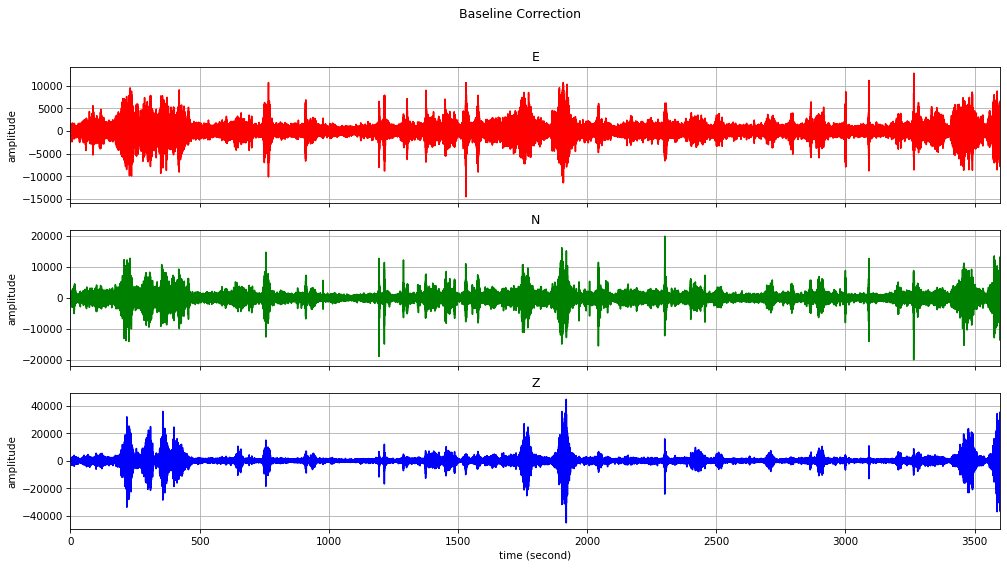

In [ ]:
_baseline_corr = streams.copy()
for stream in range(len(_baseline_corr)):
  traces = _baseline_corr[stream]
  for trace in range(len(traces)):
    _baseline_corr[stream][trace].data = baseline_correction(_baseline_corr[stream][trace])

print(_baseline_corr[-1])
visualize(_baseline_corr[-1], "Baseline Correction")

3 Trace(s) in Stream:
.KAL_6..BHE | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHN | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHZ | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples


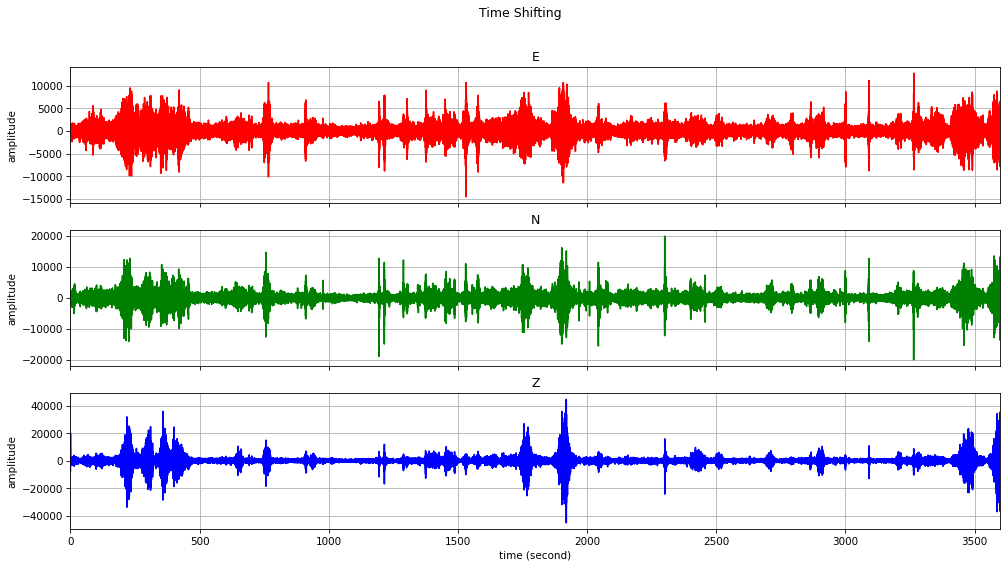

In [ ]:
_time_shifting = _baseline_corr.copy()
for stream in range(len(_time_shifting)):
  traces = _time_shifting[stream]
  for trace in range(len(traces)):
    _time_shifting[stream][trace].data = time_shifting(_time_shifting[stream][trace], shiftdata[trace])

print(_time_shifting[-1])
visualize(_time_shifting[-1], "Time Shifting")

3 Trace(s) in Stream:
.KAL_6..BHE | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHN | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples
.KAL_6..BHZ | 2022-07-05T12:00:00.220000Z - 2022-07-05T13:00:00.590000Z | 100.0 Hz, 360038 samples


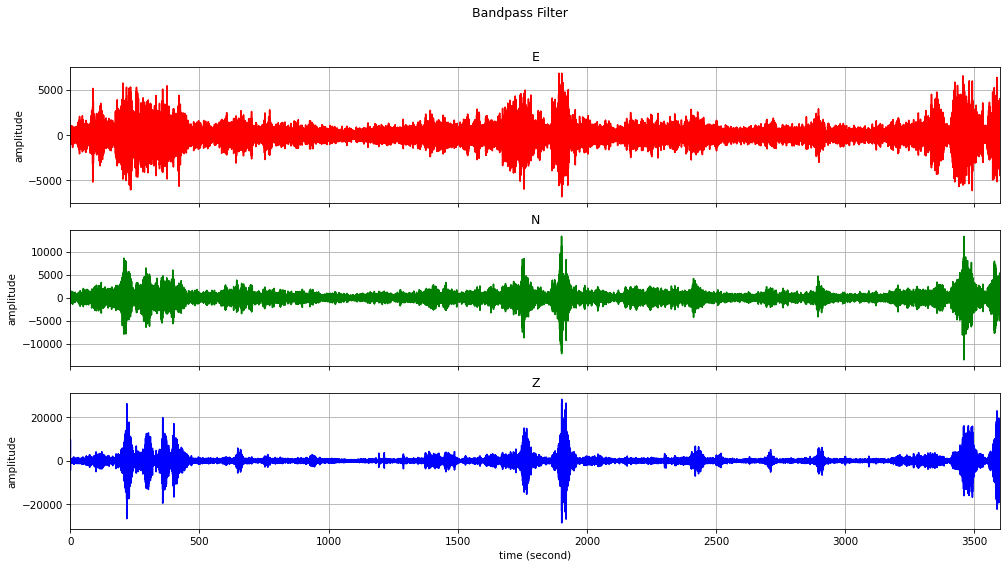

In [ ]:
_freq_filter = _time_shifting.copy()
for stream in range(len(_freq_filter)):
  traces = _freq_filter[stream]
  for trace in range(len(traces)):
    _freq_filter[stream][trace] = bandpass_filter(_freq_filter[stream][trace],
                                                  min_freq,
                                                  max_freq,)

print(_freq_filter[-1])
visualize(_freq_filter[-1], "Bandpass Filter")

3 Trace(s) in Stream:
.KAL_6..BHE | 2022-07-05T12:00:00.220000Z - 2022-07-05T12:58:10.210000Z | 100.0 Hz, 349000 samples
.KAL_6..BHN | 2022-07-05T12:00:00.220000Z - 2022-07-05T12:58:10.210000Z | 100.0 Hz, 349000 samples
.KAL_6..BHZ | 2022-07-05T12:00:00.220000Z - 2022-07-05T12:58:10.210000Z | 100.0 Hz, 349000 samples


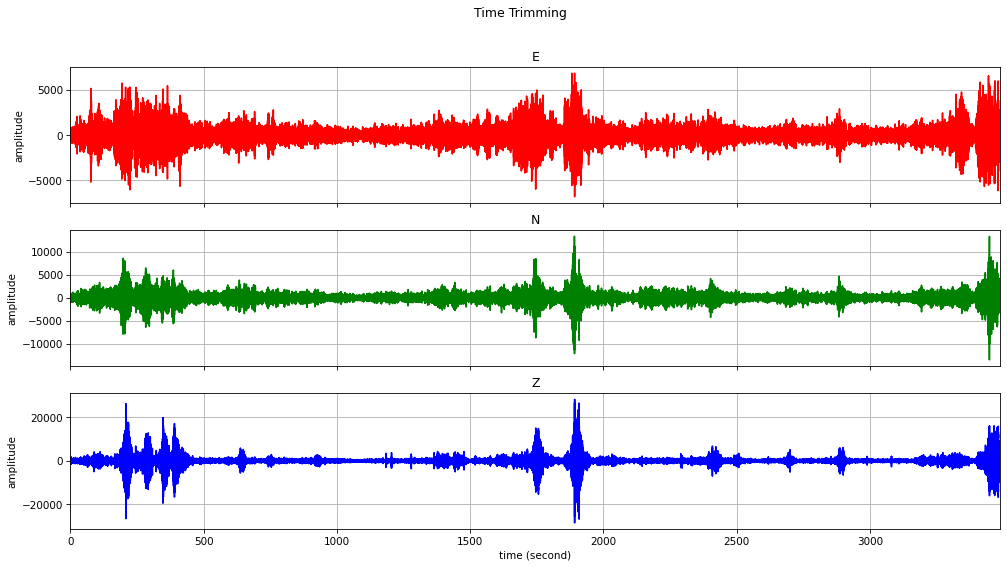

In [ ]:
_time_trimming = _freq_filter.copy()
for stream in range(len(_time_trimming)):
  traces = _time_trimming[stream]
  for trace in range(len(traces)):
    _time_trimming[stream][trace].data = time_trimming(_time_trimming[stream][trace],
                                                       start_data, data_length)

print(_time_trimming[-1])
visualize(_time_trimming[-1], "Time Trimming")

In [ ]:
_spectrum_freq = _time_trimming.copy()
dfft = []
fftfreq = []

for stream in range(len(_spectrum_freq)):
  traces = _spectrum_freq[stream]
  dfft.append([])
  fftfreq.append([])
  for trace in range(len(traces)):
    dfft[-1].append(np.fft.fft(_spectrum_freq[stream][trace].data))
    fftfreq[-1].append(np.fft.fftfreq(len(dfft[-1][-1]), _spectrum_freq[stream][trace].stats.delta))

Hitung instrument adjustment factor tiap komponen (E, N, dan Z) dengan instrumen pertama sebagai acuan -- `KAL_4.mseed`.

In [ ]:
def find_range_freq_index(trace, freqmin, freqmax):
  """
  find start and end index of frequency

  Parameters
  ---------
  trace : obspy.core.trace.Trace
    object `obspy.core.trace.Trace`.

  freqmin : int or float
    frekuensi minimum.

  freqmax : int or float
    frekuensi maksimum.

  Returns
  ---------
  ndarray
    trace seismik yang telah diseleksi berdasarkan rentang index
  """
  istart = 0
  iend = 0
  for j, jf in enumerate(trace):
    if jf < freqmin:
      istart += 1
    if jf >= freqmin:
      break
  for j, jf in enumerate(trace):
    if jf < freqmax:
      iend +=1
    if jf >= freqmax:
      break
  return istart, iend

In [ ]:
instrument_reference = 0 # file ke 1
instrument = []
adjustment_data = []

for stream in range(len(streams)):
  traces = streams[stream]
  adjustment_data.append(traces[stream].stats.station)

  print(f"Instrument {traces[stream].stats.station}")

  for component in range(len(traces)):
    # find start and end inde of frequency
    # all components of the first stream's frequency
    istart, iend = find_range_freq_index(fftfreq[0][component], min_freq, max_freq)

    # instrumen pertama merupakan acuan perbandingan
    adjustment_factor = np.divide(np.abs(dfft[instrument_reference][component][istart:iend]),
                                  np.abs(dfft[stream][component][istart:iend]))
    global_adjustment_factor = np.median(adjustment_factor)

    print(f"Adjustment factor for component ({traces[component].stats.channel[-1]}): {global_adjustment_factor}")
    adjustment_data.append(global_adjustment_factor)
  print("\n")

Instrument KAL_4
Adjustment factor for component (E): 1.0
Adjustment factor for component (N): 1.0
Adjustment factor for component (Z): 1.0


Instrument KAL_5
Adjustment factor for component (E): 0.9536920020480792
Adjustment factor for component (N): 1.0230983078055396
Adjustment factor for component (Z): 1.0459153035773092


Instrument KAL_6
Adjustment factor for component (E): 0.953923291636839
Adjustment factor for component (N): 1.0170807892631197
Adjustment factor for component (Z): 1.0423010764932927




Tampilkan hasil instrument adjustment factor tiap komponen

In [ ]:
compare_list = [0, 2] # 0 = KAL_4.mseed, 1 = KAL_5.mseed, 2 = KAL_6.mseed
component = 2 # 0 = E, 1 = N, 2 = Z

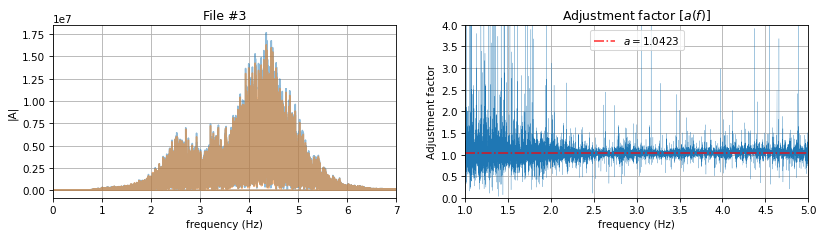

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(13,3), dpi=75, sharey=False)

for ifile in compare_list:
  x = fftfreq[ifile][component]
  y = np.abs(dfft[ifile][component])

  ax[0].plot(x, y, alpha=0.5, label=f"File #{ifile+1}")
  ax[0].set_xlabel("frequency (Hz)")
  ax[0].set_ylabel("|A|")
  ax[0].set_xlim(0,7)
  ax[0].grid('both')
  ax[0].set_title(f"File #{ifile+1}")

ax[1].plot(fftfreq[ifile][component][istart:iend],adjustment_factor,lw=0.2, alpha=1.0)
ax[1].plot([min_freq, max_freq],[global_adjustment_factor, global_adjustment_factor],'-.r', alpha=0.8,label=f"$a={global_adjustment_factor:5.4f}$")
ax[1].set_xlim(min_freq, max_freq)
ax[1].set_ylim(0,4)
ax[1].grid('both')
ax[1].set_title(f"Adjustment factor [$a(f)$]")
ax[1].set_xlabel("frequency (Hz)")
ax[1].set_ylabel("Adjustment factor")
ax[1].legend()

In [ ]:
data = np.reshape(adjustment_data, (3,4))
data = pd.DataFrame(data, columns=['Instrument', 'E', 'N', 'Z'])
data

,Instrument,E,N,Z
0,KAL_4,1.0,1.0,1.0
1,KAL_5,0.9536920020480792,1.0230983078055396,1.0459153035773092
2,KAL_6,0.953923291636839,1.0170807892631197,1.0423010764932927
